In [1]:
import pandas as pd
import numpy as np

In [2]:
ratings = pd.read_csv("../../ml-small/ratings.csv")

In [3]:
movie_rating_count = ratings.groupby("movieId").size()
movie_rating_count[movie_rating_count.lt(4)]

movieId
30        3
40        2
49        1
53        2
54        3
         ..
193581    1
193583    1
193585    1
193587    1
193609    1
Length: 5544, dtype: int64

<AxesSubplot:ylabel='Frequency'>

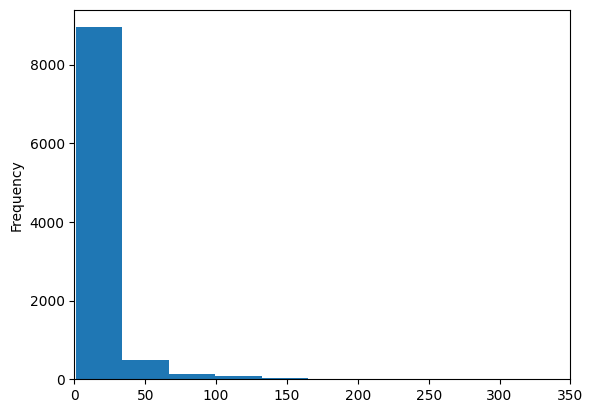

In [4]:
movie_rating_count.plot(kind="hist", xlim=(0, 350))

In [5]:
remove_movie_id = movie_rating_count[movie_rating_count.lt(4)].index.values.tolist()

In [6]:
new_ratings = ratings[~ratings.movieId.isin(remove_movie_id)]

In [7]:
movieId = sorted(list(set(new_ratings["movieId"])))
# movieId_subset = movieId[:5000]
# movieId_max = max(movieId_subset)
# ratings_subset = ratings[ratings["movieId"] <= movieId_max]

In [ ]:
# user_data = list(ratings["userId"])
# ratings_data = list(ratings["rating"])
# item_data = list(ratings["movieId"])

# from scipy.sparse import csr_matrix
# ratings_matrix = csr_matrix((ratings_data, (user_data, item_data)))

### Split to Train and Test Data

In [8]:
# split data into train and test by userId
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_ratings, test_size=0.2, random_state=3, stratify=new_ratings["movieId"])

In [9]:
train_rating_count = train.groupby("movieId").size()
train_rating_count.min()

3

In [10]:
from scipy.sparse import csr_matrix

train_user_data = list(train["userId"])
train_ratings_data = list(train["rating"])
train_item_data = list(train["movieId"])
train_matrix = csr_matrix((train_ratings_data, (train_user_data, train_item_data)))

test_user_data = list(test["userId"])
test_ratings_data = list(test["rating"])
test_item_data = list(test["movieId"])
test_matrix = csr_matrix((test_ratings_data, (test_user_data, test_item_data)))

In [11]:
train_movieId = sorted(list(set(train_item_data)))
test_movieId = sorted(list(set(test_item_data)))

In [ ]:
# for i in movieId:
#     if i not in train_movieId:
#         print(i)
# i = 90
# train_movieId[train_movieId.index(i) + 1]

# print(train_movieId)

### Cosine Similarity Computation

In [ ]:
# cosine_sim_values = pd.DataFrame(np.nan, columns=["item1", "item2", "cosine_similarity"])
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import trange

cosine_sim_values = []
# movieId = sorted(list(set(ratings["movieId"])))

for item1_index in trange(len(train_movieId), desc="1st loop"):
    i = train_movieId[item1_index]
    for item2_index in range(item1_index + 1, len(train_movieId)):
        j = train_movieId[item2_index]
        target = train_matrix[:, [i, j]]
        df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
        df = df.replace(0, np.nan)
        df = df[~df.isnull().any(axis=1)]
        if df.shape[0] > 2:
            cos_sim = cosine_similarity(df["col1"].values.reshape(1, -1), df["col2"].values.reshape(1, -1))
            dict = {"item1": i, "item2": j, "cosine_similarity": cos_sim[0][0]}
            cosine_sim_values.append(dict)

In [ ]:
cosine_sim_values = pd.DataFrame(cosine_sim_values)
cosine_sim_values

In [ ]:
cosine_sim_values["cosine_similarity"].plot(kind="kde")

In [ ]:
cosine_sim_values.to_csv("train_cosine_similarity.csv")

In [ ]:
# target = train_matrix[:, [1, 1740]]
# df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
# df = df.replace(0, np.nan)
# df = df[~df.isnull().any(axis=1)]
# df.shape[0]
# if df.shape[0] >= 5:
#     cos_sim = cosine_similarity(df["col1"].values.reshape(1, -1), df["col2"].values.reshape(1, -1))
#     print("run")
# df.shape[0] < 5

### Correlation-based Similarity

In [ ]:
from sklearn.metrics import pairwise_distances
from tqdm.auto import trange
# import warnings

# warnings.filterwarnings("error")
corr_sim_values = []
# movieId = sorted(list(set(ratings["movieId"])))

for item1_index in trange(len(train_movieId), desc="1st loop"):
    i = train_movieId[item1_index]
    for item2_index in range(item1_index + 1, len(train_movieId)):
        j = train_movieId[item2_index]
        target = train_matrix[:, [i, j]]
        df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
        df = df.replace(0, np.nan)
        df = df[~df.isnull().any(axis=1)]
        if df.shape[0] > 2:
            correlation = df["col1"].corr(df["col2"])
            dict = {"item1": i, "item2": j, "correlation": correlation}
            corr_sim_values.append(dict)
            # warnings.warn(Warning())

In [ ]:
corr_sim_values = pd.DataFrame(corr_sim_values)
corr_sim_values

In [ ]:
corr_sim_values["correlation"].plot(kind="kde")

In [ ]:
corr_sim_values.to_csv("train_correlation_similarity.csv")

In [ ]:
# target = train_matrix[:, [1, 61]]
# df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
# df = df.replace(0, np.nan)
# df = df[~df.isnull().any(axis=1)]
# correlation = df["col1"].corr(df["col2"])
# dict = {"item1": i, "item2": j, "correlation": correlation}
# df

### Adjusted-Cosine Similarity

In [ ]:
from tqdm.auto import trange
from math import sqrt
# import warnings

# warnings.filterwarnings("error")
adj_cosine_sim_values = []
# movieId = sorted(list(set(ratings["movieId"])))

for item1_index in trange(len(train_movieId), desc="1st loop"):
    i = train_movieId[item1_index]
    for item2_index in range(item1_index + 1, len(train_movieId)):
        j = train_movieId[item2_index]
        target = train_matrix[:, [i, j]]
        df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
        df = df.replace(0, np.nan)
        df = df[~df.isnull().any(axis=1)]
        if df.shape[0] > 2:
            df_userId = df.index.tolist()
            df_user_ratings = train[train["userId"].isin(df_userId)]
            avg_user_ratings = df_user_ratings.groupby(["userId"]).mean()["rating"]
            df_sub_avg = df.sub(avg_user_ratings, axis="index") # subtract user average
            adj_cos = (df_sub_avg["col1"]*df_sub_avg["col2"]).sum()/(sqrt((df_sub_avg["col1"]**2).sum())*sqrt((df_sub_avg["col2"]**2).sum()))
            dict = {"item1": i, "item2": j, "adjusted_cosine_similarity": adj_cos}
            adj_cosine_sim_values.append(dict)

In [ ]:
adj_cosine_sim_values = pd.DataFrame(adj_cosine_sim_values)
adj_cosine_sim_values

In [ ]:
adj_cosine_sim_values["adjusted_cosine_similarity"].plot(kind="kde")

In [ ]:
adj_cosine_sim_values.to_csv("train_adjusted_cosine_similarity.csv")

In [ ]:
# target = train_matrix[:, [1, 270]]
# df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
# df = df.replace(0, np.nan)
# df = df[~df.isnull().any(axis=1)]
# df_userId = df.index.tolist()
# df_user_ratings = train[train["userId"].isin(df_userId)]
# avg_user_ratings = df_user_ratings.groupby(["userId"]).mean()["rating"]
# df_sub_avg = df.sub(avg_user_ratings, axis="index") # subtract user average
# # adj_cos = (df_sub_avg["col1"]*df_sub_avg["col2"]).sum()/(sqrt((df_sub_avg["col1"]**2).sum())*sqrt((df_sub_avg["col2"]**2).sum()))
# df_sub_avg

## Try (ignore this section)

In [ ]:
# without zero row and col since userId and movieId starts from 1
from scipy.sparse import csr_matrix
n_users = ratings.userId.max()
n_movies = ratings.movieId.max()
ratings_data = ratings.rating
user_data = ratings.userId
item_data = ratings.movieId
adj_matrix = csr_matrix((ratings_data, (user_data - 1, item_data - 1)), shape = (n_users, n_movies))
adj_matrix.shape

In [ ]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]

In [ ]:
# change ratings to binary because of sparse dataset
# 0 if rating <= 2.5, 1 if rating > 2.5
# ratings["rating"] = ratings["rating"].gt(2.5).astype("int")

In [ ]:
user_rating_count = ratings.groupby("userId").size()
user_rating_count[user_rating_count.lt(20)]